# Exploration: Mississippi Impaired Water Designations and NPDES permit limit changes
<i> Ryan Treves
### Overarching question:
- What is the connection between impaired water designations and NPDES permit limit changes? Specifically, how many impaired waters designations in MS produce permit limit changes?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

# Suppressing warning messages
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify vars to parse as dates
date_vars = ['limit_begin_date', 'limit_end_date', 'monitoring_period_end_date', 'monitoring_period_end_month', 'monitoring_period_quarter_start', 'monitoring_period_quarter_end', 'value_received_date', 'value_received_month', 'value_received_quarter_start', 'value_received_quarter_end']
# Load in DMR data
MS_dmrs = pd.read_csv('~/Documents/DMR work/DMR Python Projects/dmr-permit-limit-changes/dmr_data/MS_dmrs.csv', dtype={
                            'perm_feature_nmbr': object,
                             'limit_unit_code': object,
                             'standard_unit_code': object,
                             'dmr_unit_desc': str,
                             'dmr_unit_code': object
                         }, parse_dates=date_vars, date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

# Load in data on impaired waters and permits
impaired_waters = pd.read_csv('impaired_waters.csv', dtype={'HUC12': object})
permits = pd.read_csv('MS_permits.csv', dtype={'wbd_huc12': object}).rename(columns={'wbd_huc12':'HUC12'})

Constructing limit value time series

In [3]:
# For each NPDES permit, permit features, parameter, and limit type-- construct time series of limit values over time

# Variables to include in time series
limit_ids = ['limit_id', 'limit_value_id']
limit_times = ['limit_begin_date', 'limit_end_date']
limit_unique = ['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'statistical_base_code', 'statistical_base_type_code']
limit_vals = ['limit_value_nmbr', 'limit_value_standard_units', 'standard_unit_desc']

# Obtain limit values over time from DMR data
# Exclude missing limit values
excl_missing_lv = MS_dmrs.dropna(subset=['limit_value_nmbr'])
# Drop DMRs with duplicate limit variables
limit_time_series = excl_missing_lv[limit_ids + limit_unique + limit_times + limit_vals].drop_duplicates()
print('DMRs with duplicate limit variables dropped: ', len(MS_dmrs) - len(limit_time_series))

# Sort limit values
limit_time_series.sort_values(by=limit_unique + limit_times + limit_vals, inplace=True)
limit_time_series.head()

DMRs with duplicate limit variables dropped:  3364167


,limit_id,limit_value_id,npdes_permit_id,perm_feature_nmbr,parameter_desc,limit_value_type_code,statistical_base_code,statistical_base_type_code,limit_begin_date,limit_end_date,limit_value_nmbr,limit_value_standard_units,standard_unit_desc
5,3200110659,3200553298,MS0000078,001,Oil & Grease,C2,MK,AVG,2007-07-01,2012-05-31,10.0,10.0,mg/L
581523,3200110655,3200553278,MS0000078,001,Oil & Grease,C2,MK,AVG,2012-07-25,2017-06-30,10.0,10.0,mg/L
1908881,3602973461,3605069675,MS0000078,001,Oil & Grease,C2,MK,AVG,2017-11-27,2022-10-31,10.0,10.0,mg/L
16,3200110659,3200553299,MS0000078,001,Oil & Grease,C3,DD,MAX,2007-07-01,2012-05-31,15.0,15.0,mg/L
581532,3200110655,3200553279,MS0000078,001,Oil & Grease,C3,DD,MAX,2012-07-25,2017-06-30,15.0,15.0,mg/L


In [4]:
# First, finding duplicates on limit id x time
find_dups = limit_time_series.groupby(limit_ids + limit_times).size().reset_index(name='counts')

# Print the counts of limits id x time combinations by how many times they appear in the dataset
find_dups['counts'].value_counts()

1    107403
2      4545
Name: counts, dtype: int64

In [5]:
# Flag duplicates on all known identifiers
find_dups_all = limit_time_series.groupby(limit_unique + limit_times).size().reset_index(name='counts') # Count number of duplicates using the unique identifiers and time as ID variables
find_dups_all = limit_time_series.merge(find_dups_all, how='left', on=limit_unique + limit_times)
find_dups_all['counts'].value_counts()

1     102893
2      13374
4        148
10        40
3         24
8          8
6          6
Name: counts, dtype: int64

In [6]:
# For now, drop limits if they are not unique on our identifiers
pre_length = len(limit_time_series)
limit_time_series = find_dups_all[find_dups_all['counts']==1]
print("Number of limits dropped: ", pre_length-len(limit_time_series))
# notes about duplicated data:
# some of the duplicates (e.g. for permit_id MS0003115 pH) have depulicated limit values; can just drop the id variable and then de-dup
# some duplicates contain different limit values for different observations (e.g. for permit_id MS0034436 Flow, in conduit or thru treatment plant). this at least doesn't seem to change over time? not sure what happens to the limit values
# for now, ignore

Number of limits dropped:  13600


Constructing flag for actual permit limit change

In [7]:
# Compare to flagged value; if limit_value_standard_units != prev then there was a change
limit_time_series_df = limit_time_series
limit_time_series_df['prev_limit_value_nmbr'] = limit_time_series_df.groupby(limit_unique)[['limit_value_nmbr']].shift()

limit_time_series_df['prev_limit_value_standard_units'] = limit_time_series_df.groupby(limit_unique)[['limit_value_standard_units']].shift()
condition1 = limit_time_series_df['prev_limit_value_nmbr'].notna()
condition2 = limit_time_series_df['limit_value_nmbr'] != limit_time_series_df['prev_limit_value_nmbr']
limit_time_series_df['limit_change'] = np.where(condition1 & condition2, 1, 0)

In [8]:
#  Calculate limit change % difference
limit_time_series_df['limit_change_pct'] = 100*(limit_time_series_df['limit_value_standard_units']-limit_time_series_df['prev_limit_value_standard_units'])/limit_time_series_df['prev_limit_value_standard_units']
limit_time_series_df['limit_change_pct'] = np.where(limit_time_series_df['limit_change']==0, np.nan, limit_time_series_df['limit_change_pct']) # if there is no limit change, represent limit_change_pct as NaN

How many limit series have ever changed?

In [22]:
limit_time_series_df.drop_duplicates(subset=['limit_value_id', 'limit_id'])['limit_change'].value_counts()

0    97114
1     5768
Name: limit_change, dtype: int64

In [10]:
limit_changes = limit_time_series_df[limit_time_series_df['limit_change']==1]
limits_unchanged = limit_time_series_df[limit_time_series_df['limit_change']==0]

In [11]:
# Find NPDES permittees that have outfalls onto waters that have ever been designated as impaired
impaired_permits = permits.merge(impaired_waters, how='inner', on='HUC12')
impaired_permits.to_csv('impaired_permits.csv')

How many HUC12 codes are represented in the list of impaired waters permits?

In [12]:
impaired_permits.drop_duplicates(subset=['HUC12']).shape[0]

154

How many impaired waters were left behind after the merge?

In [13]:
hucs = list(impaired_permits['HUC12'].unique())
unmatched = impaired_waters[impaired_waters['HUC12'].apply(lambda x: x not in hucs)]
len(unmatched.drop_duplicates(subset=['HUC12']))

49

49 impaired waters were not matched by HUC12 code to the MS permits list.

In [24]:
impaired_changed_permits = impaired_permits.merge(limit_changes, how='inner', on='npdes_permit_id')
impaired_unchanged_permits = impaired_permits.merge(limits_unchanged, how='inner', on='npdes_permit_id')

In [25]:
impaired_changed_permits['FIRST LISTED '] = pd.to_datetime(impaired_changed_permits['FIRST LISTED '], errors='coerce')
impaired_changed_permits = impaired_changed_permits.rename(columns={'FIRST LISTED ': 'Year first listed'})
impaired_changed_permits['delay'] = impaired_changed_permits.limit_begin_date-impaired_changed_permits['Year first listed']
delays = impaired_changed_permits[impaired_changed_permits['delay'].dt.days>=0].drop_duplicates(subset=['limit_id', 'limit_value_id'])['delay']

How permits could not be matched to any limit?

In [16]:
impaired_permits.merge(limit_time_series_df, how='inner', on='npdes_permit_id').drop_duplicates(subset=['limit_value_id', 'limit_id']).shape[0]-787-16983

0

In [17]:
impaired_changed_permits.to_csv('impaired_changed_permits.csv')

Among limit series that changed after the corresponding waterway was impaired, what is the distribution of delay times until the date of the limit change after the impairment?

(array([65., 94., 74., 70., 70., 61., 25.,  5., 16., 10.]),
 array([   0. ,  699.9, 1399.8, 2099.7, 2799.6, 3499.5, 4199.4, 4899.3,
        5599.2, 6299.1, 6999. ]),
 <BarContainer object of 10 artists>)

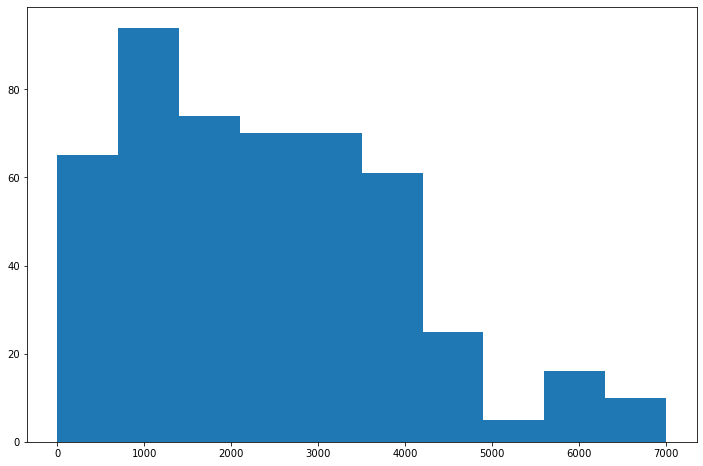

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(delays.dt.days)

In [30]:
print('Numbers are in terms of limit series')
A = impaired_unchanged_permits.drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # Unchanged impaired water limit series
unchanged_permits = permits.merge(limits_unchanged, how='inner', on='npdes_permit_id')
B = unchanged_permits.drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # Unchanged limit series
C = impaired_changed_permits.drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # Changed impaired water limit series
D = permits.merge(limit_changes, how='inner', on='npdes_permit_id').drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # Changed water limit series

E = impaired_changed_permits[impaired_changed_permits['delay'].dt.days>=0].drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # Limit series that changed after an impairment
F = impaired_changed_permits[(impaired_changed_permits['delay'].dt.days>=0) & (impaired_changed_permits['delay'].dt.days<365*3)].drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # ...within 3 years
G = impaired_changed_permits[(impaired_changed_permits['delay'].dt.days>=0) & (impaired_changed_permits['delay'].dt.days<365*2)].drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # ...within 2 years
H = impaired_changed_permits[(impaired_changed_permits['delay'].dt.days>=0) & (impaired_changed_permits['delay'].dt.days<365)].drop_duplicates(subset=['limit_id', 'limit_value_id']).shape[0] # ...within 1 year

pd.DataFrame({'Limit constant': [A, B-A], 'Limit change ever':[C, D-C], 'Limit change on/after first impairment':[E, 'NA'], 'Limit change within 3 yrs of first impairment': [F, 'NA'], 'Limit change within 2 yrs of first impairment': [G, 'NA'], 'Limit change within 1 yr of first impairment': [H, 'NA']}, {'Ever impaired', 'Never impaired'}).T

Numbers are in terms of limit series


,Ever impaired,Never impaired
Limit constant,16983,80131
Limit change ever,787,4981
Limit change on/after first impairment,490,NA
Limit change within 3 yrs of first impairment,118,NA
Limit change within 2 yrs of first impairment,79,NA
Limit change within 1 yr of first impairment,36,NA


What about in terms of waters?

In [29]:
limit_change_hucs = list(impaired_changed_permits.drop_duplicates(subset='HUC12')['HUC12'])
A = impaired_unchanged_permits[impaired_unchanged_permits['HUC12'].apply(lambda x: x not in limit_change_hucs)].drop_duplicates(subset='HUC12').shape[0] # All never-changing limit impaired HUCs

unchanged_permits = permits.merge(limits_unchanged, how='inner', on='npdes_permit_id')
B = unchanged_permits[unchanged_permits['HUC12'].apply(lambda x: x not in limit_change_hucs)].drop_duplicates(subset=['HUC12']).shape[0] # All never-changing limit HUCs
C = impaired_changed_permits.drop_duplicates(subset=['HUC12']).shape[0] # Impaired limit change HUCs
D = permits.merge(limit_changes, how='inner', on='npdes_permit_id').drop_duplicates(subset=['HUC12']).shape[0] # All limit change HUCs

E = impaired_changed_permits[impaired_changed_permits['delay'].dt.days>=0].drop_duplicates(subset=['HUC12']).shape[0] # HUC12s that had a limit change after an impairment
F = impaired_changed_permits[(impaired_changed_permits['delay'].dt.days>=0) & (impaired_changed_permits['delay'].dt.days<365*3)].drop_duplicates(subset=['HUC12']).shape[0] #...within 3 years
G = impaired_changed_permits[(impaired_changed_permits['delay'].dt.days>=0) & (impaired_changed_permits['delay'].dt.days<365*2)].drop_duplicates(subset=['HUC12']).shape[0] #...within 2 years
H = impaired_changed_permits[(impaired_changed_permits['delay'].dt.days>=0) & (impaired_changed_permits['delay'].dt.days<365)].drop_duplicates(subset=['HUC12']).shape[0] #...within 1 year
print('Numbers are in terms of HUC12 waters')
pd.DataFrame({'All limits constant': [A, B-A], 'Limit change ever':[C, D-C], 'Limit change on/after first impairment':[E, 'NA'], 'Limit change within 3 yrs of first impairment': [F, 'NA'], 'Limit change within 2 yrs of first impairment': [G, 'NA'], 'Limit change within 1 yr of first impairment': [H, 'NA']}, {'Ever impaired', 'Never impaired'}).T

Numbers are in terms of HUC12 waters


,Ever impaired,Never impaired
All limits constant,47,609
Limit change ever,66,327
Limit change on/after first impairment,45,NA
Limit change within 3 yrs of first impairment,18,NA
Limit change within 2 yrs of first impairment,15,NA
Limit change within 1 yr of first impairment,10,NA
